In [ ]:
cd ~/Google\ Drive/My

/Users/mm/Library/CloudStorage/GoogleDrive-mmaddipatla@umass.edu


In [ ]:
%ls

My Drive/      Shared drives/


In [ ]:
exp = "exp050_llama"
device_id = 0

In [ ]:
cd '/Users/mm/Library/CloudStorage/GoogleDrive-mmaddipatla@umass.edu/My Drive/682-Project/GIT-LLM'

/Users/mm/Library/CloudStorage/GoogleDrive-mmaddipatla@umass.edu/My Drive/682-Project/GIT-LLM


# Requirements Installation

In [ ]:
pip install -r requirements.txt

  Cloning https://github.com/huggingface/peft.git (to revision 0b62b4378b4ce9367932c73540349da9a41bdea8) to /private/var/folders/08/r6k1d6tj0_z_jdjxm7vn6f5w0000gn/T/pip-install-29u526pe/peft_1f5fbba447e94e60afe88a2686861829
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/peft.git /private/var/folders/08/r6k1d6tj0_z_jdjxm7vn6f5w0000gn/T/pip-install-29u526pe/peft_1f5fbba447e94e60afe88a2686861829
  Running command git rev-parse -q --verify 'sha^0b62b4378b4ce9367932c73540349da9a41bdea8'
  Running command git fetch -q https://github.com/huggingface/peft.git 0b62b4378b4ce9367932c73540349da9a41bdea8
  Running command git checkout -q 0b62b4378b4ce9367932c73540349da9a41bdea8
  Resolved https://github.com/huggingface/peft.git to commit 0b62b4378b4ce9367932c73540349da9a41bdea8
  Installing build dependencies ... - \ | done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Cloning https://github.com/h

In [ ]:
!pip install japanize_matplotlib

# Imports


In [ ]:
import glob
import os
import sys
from base64 import b64decode
from io import BytesIO
from PIL import Image

from transformers import (
    AutoTokenizer,
    CLIPImageProcessor,
    AutoProcessor,
    TrainingArguments,
    Trainer,
    AutoModelForCausalLM
)
import datasets
import torch
from torch.utils.data import Dataset
import yaml
import deepspeed
import fire
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from peft import LoraConfig, get_peft_config, get_peft_model

from git_opt.modeling_git_opt import GitOPTForCausalLM, GitOPTConfig
from git_llama.modeling_git_llama import GitLlamaForCausalLM, GitLlamaConfig

[2023-12-06 01:02:52,675] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to mps (auto detect)


NOTE: Redirects are currently not supported in Windows or MacOs.


ModuleNotFoundError: ignored

In [ ]:
sys.path.append('..')
from train import load_model, apply_lora_model

# Functions

In [ ]:
def generate_text(model, data):
    eos_token_id_list = [
        supervised_test_dataset.processor.tokenizer.pad_token_id,
        supervised_test_dataset.processor.tokenizer.eos_token_id,
    ]
    with torch.no_grad():
        out = model.generate(**data, max_length=256, do_sample=False, temperature=0., eos_token_id=eos_token_id_list)
        return supervised_test_dataset.processor.tokenizer.batch_decode(out)

# SupervisedDataset
class SupervisedDataset(Dataset):
    """Dataset for supervised learning"""

    def __init__(
        self,
        model_name: str,
        vision_model_name: str,
        loaded_dataset: datasets.GeneratorBasedBuilder,
        max_length: int = 128,
    ):
        super(SupervisedDataset, self).__init__()
        self.loaded_dataset = loaded_dataset
        self.max_length = max_length

        self.processor = AutoProcessor.from_pretrained("microsoft/git-base")
        self.processor.image_processor = CLIPImageProcessor.from_pretrained(vision_model_name)
        self.processor.tokenizer = AutoTokenizer.from_pretrained(
            model_name, padding_side="right", use_fast=False
        )
        if "llama" in model_name:
            self.processor.tokenizer.pad_token = self.processor.tokenizer.eos_token

    def __len__(self) -> int:
        return len(self.loaded_dataset)

    def __getitem__(self, index) -> dict:
        # cf: https://huggingface.co/datasets/MMInstruction/M3IT#data-instances
        row = self.loaded_dataset[index]

        instruction = row["instruction"]  # str
        question = row["inputs"]  # str
        answer = row["outputs"]  # str
        full_text = f"##Instruction: {instruction} ##Question: {question} ##Answer: {answer}"
        text = f"##Instruction: {instruction} ##Question: {question} ##Answer:"

        # imageのロード
        image_base64_str_list = row["image_base64_str"]  # str (base64)
        img = Image.open(BytesIO(b64decode(image_base64_str_list[0])))

        inputs = self.process_data(text, img)

        return inputs, img, text, full_text

    def process_data(self, text, img):
        inputs = self.processor(
            text,
            img,
            return_tensors="pt",
            # max_length=self.max_length,
            # padding="max_length",
            truncation=True,
        )
        inputs = {k: v.to(f"cuda:{device_id}") for k, v in inputs.items()}
        inputs["pixel_values"] = inputs["pixel_values"].to(torch.float16)
        inputs["labels"] = None
        return inputs

# Load configs

In [ ]:
config_file = f"../configs/training_config_{exp}.yml"

# get config
with open(config_file, "r") as i_:
    config = yaml.safe_load(i_)


# model
model_name = config["settings"]["model_name"]
vision_model_name = config["settings"]["vision_model_name"]
num_image_with_embedding = config["settings"]["num_image_with_embedding"]

keys_finetune = config["settings"]["keys_finetune"]

# Load a pretrained model

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 

In [ ]:
model = load_model(model_name, vision_model_name, num_image_with_embedding)

# lora
if config["use_lora"]:
    keys_finetune.append("lora")
    model = apply_lora_model(model, model_name, config)

weight = {}
weight_path = glob.glob(f'../output/{exp}/checkpoint*/pytorch*.bin')
for w in weight_path:
    weight_temp = torch.load(w, map_location="cpu")
    weight.update(weight_temp)
model.load_state_dict(weight, strict=False)

model.eval()
model.to(f"cuda:{device_id}")
print("Complete preparing an eval model")

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

You are using a model of type llama to instantiate a model of type git_llama. This is not supported for all configurations of models and can yield errors.


config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of GitLlamaForCausalLM were not initialized from the model checkpoint at meta-llama/Llama-2-7b-chat-hf and are newly initialized: ['model.image_encoder.vision_model.encoder.layers.5.self_attn.q_proj.bias', 'model.image_encoder.vision_model.encoder.layers.3.mlp.fc2.bias', 'model.image_encoder.vision_model.encoder.layers.8.self_attn.k_proj.bias', 'model.image_encoder.vision_model.encoder.layers.11.self_attn.v_proj.bias', 'model.image_encoder.vision_model.encoder.layers.0.self_attn.out_proj.bias', 'model.image_encoder.vision_model.encoder.layers.1.self_attn.out_proj.bias', 'model.image_encoder.vision_model.encoder.layers.1.self_attn.q_proj.weight', 'model.image_encoder.vision_model.encoder.layers.8.layer_norm1.weight', 'model.image_encoder.vision_model.encoder.layers.7.self_attn.k_proj.weight', 'model.image_encoder.vision_model.encoder.layers.10.mlp.fc2.weight', 'model.image_encoder.vision_model.encoder.layers.1.layer_norm1.bias', 'model.image_encoder.vision_model.encoder.lay

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

Complete preparing an eval model


# Inference

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset m3_it downloaded and prepared to /root/.cache/huggingface/datasets/MMInstruction___m3_it/coco/1.0.1/f456c28c5ed4849c1ef1076972bd9641f7e2df57480b2efa3a767c39cbf56494. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


--------------------
['<s>##Instruction: Write a succinct description of the image, capturing its main components, the relationships between them, and any notable details. ##Question:  ##Answer: are the main, are the main, are the main, are the main, are the main, are the main, the main, are the main, are the main: are the main: are the main: are the main: are the main: are the main: are the main: are the main: are the main: are the main: are the main: are the main: are the main: are the main: are: the main: are: the main: are: the main: are: the main: are: the main: are: the main: are: the main: the main: are: the main: the main: are: the main: the main: the main: are: the main: the main: the main: the main: the main: the main: the main: the main: the main: the main: the main: the main: the main: the main: the main: the main: the main: the main: the main: the main: the main: the main: the main: the main: the']
##Instruction: Write a succinct description of the image, capturing its mai

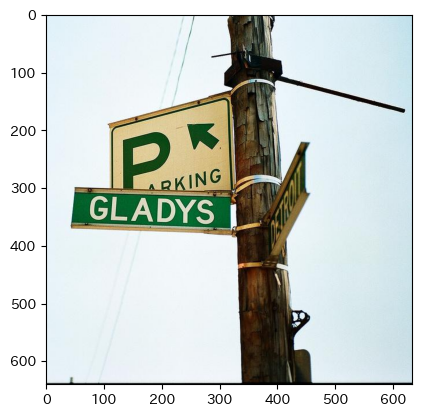

--------------------
['<s>##Instruction: Create a concise caption that accurately describes the main elements in the image provided. ##Question:  ##Answer: the issue, the issue, the issue, the issue, the issue, the Le, the Le, the Le, the Le, the Le, the Le, the Le, the Le, the Le, the Le, the Le, the Le, the Le, the Le, the Le, the Le, the Le, the Le, the Le, the Le, the Le, the Le, the Le, the, the, the, Le, the, the, the, Le, the, the, the, Le, the, the, the, Le, the, the, the, Le, the, the, Le, the, the, the, Le, the, the, Le, the, the, Le, the, the, Le, the, the, Le, the, the, Le, the, the, Le, the, Le, the, the, Le, the, Le, the, Le, the, Le, the, Le, the, Le, the, Le, theH, theLe, Le, theH, theLe, Le, theH']
##Instruction: Create a concise caption that accurately describes the main elements in the image provided. ##Question:  ##Answer: A man with a snowboard next to a man with a mask.


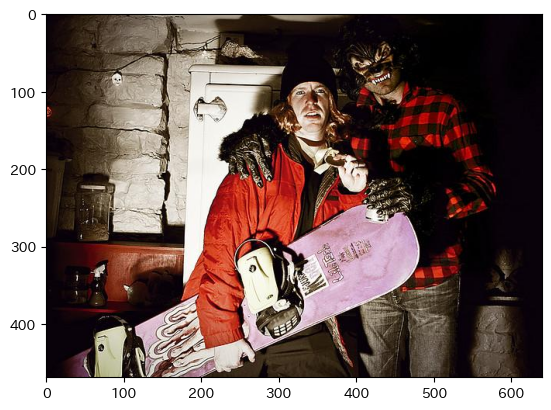

--------------------
["<s>##Instruction: Write a succinct description of the image, capturing its main components, the relationships between them, and any notable details. ##Question:  ##Answer: the main, the main, the main, the main.', we.\n the main.', the main.\n', we.\n.'.\n>>.\n.'.\nWe.\n.'\n.'\n.'\n\n.'\n.'\n.'\n\n.'\n.'\n\n.'\n\n.'\n.'\n\n.'\n\n.'\n\n.'\n\n.'\n\n\n.'\n\n\n.'\n\n\n\n\n.'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n.'\n\n\n\n\n\n\n\n.'\n\n\n\n\n\n\n'.'\n\n\n\n\n\n\n ....'\n\n\n\n\n\n\n\n ....'\n\n\n\n\n\n\n\n\n ....'\n"]
##Instruction: Write a succinct description of the image, capturing its main components, the relationships between them, and any notable details. ##Question:  ##Answer: A cow standing near a curb in front of a store.


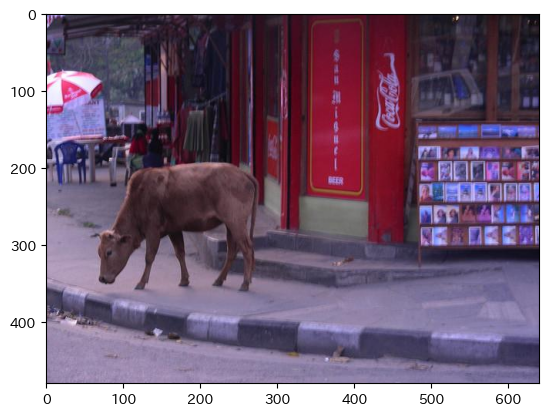

--------------------
['<s>##Instruction: Describe the image briefly. ##Question:  ##Answer: this land, and you, and you, and you, and you, and you, and you, and you, and you, and you, and you, and you, and you, and you, and you, and you, and you, and you, and you, and you, and you, and you, you, and you, and you, you, and you, you, and you, you, and you, you. and you: you. and you. you. you. you. you.\n you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you. you.']
##Instruction: Describe the image briefly. ##Question:  ##Answer: a cat that is eating some kind of banana


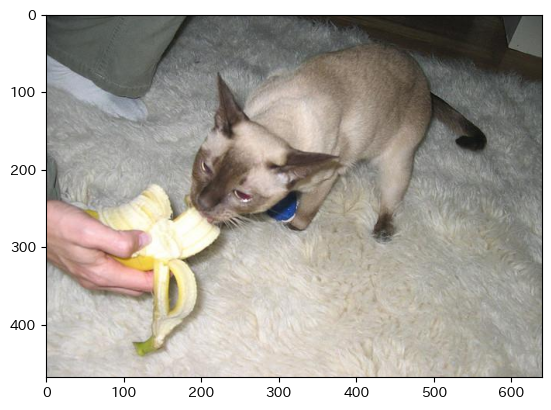

--------------------
['<s>##Instruction: Write a succinct description of the image, capturing its main components, the relationships between them, and any notable details. ##Question:  ##Answer: from the property, via, this property, via, this, the, via, the, and present, this, via, the, the, present, this, via, the, the, present, the, via, the, present, the, via, the, present, the, via, the, present, the, present, the, via, the, present, the, present, the, present, the, present, the, present, the, present, the, present, the, present, the, present, the, present, the, present, the, present, the, present, the, present, the present, present, the present, the present, present, the present, the present, present, the present, present, the present, present, the present, present, the present, present, the present, present, the present, present, the present, present, the present, present, present, the present, present, present, the present, present, present, the present: present, present, the p

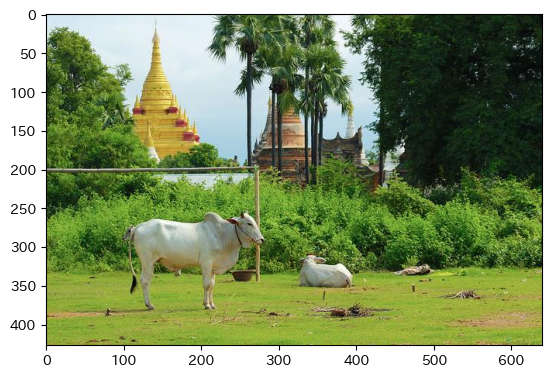

--------------------
['<s>##Instruction: Describe the image briefly. ##Question:  ##Answer: this year, for the main, this year, for the main, this year, for the main, for the main, this year, for the main, for the main, this year, for the main, for the main, for the main.\n\n\n\n for the main, for the main.\n\n\n for the main.\n\n for the main.\n\n main.\n for the main.\n\n\n for main.\n\n main.\n\n for the main.\n\n main.\n\n for the main.\n\n\n main.\n\n\n main.\n\n for main.\n\n\n main.\n\n\n main.\n\n main.\n\n\n main.\n\n\n main.\n\n\n main.\n\n\n main.\n\n\n main.\n\n main.\n\n\n main.\n\n main.\n\n main.\n\n main.\n\n main.\n\n main.\n\n main.\n\n main.\n\n main.\n\n main.\n\n main.\n\n\n main.\n\n main.\n\n main.\n\n main.\n\n main.\n\n main']
##Instruction: Describe the image briefly. ##Question:  ##Answer: An image of a very cute girl with face piercings.


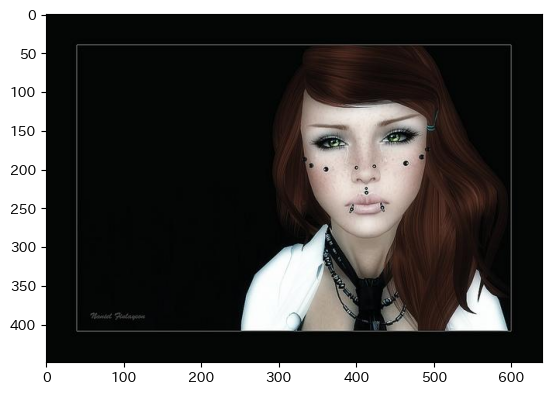

--------------------
['<s>##Instruction: For the given image, provide a one-sentence summary that captures the most important details. ##Question:  ##Answer: this land, and the land, and the. This. We. We. We. We. This. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the. the.']
##Instruction: For the given image, provide a one-sentence summary that captures the most important details. ##Question:  ##Answer: An elephant standing under the shade of a tree.


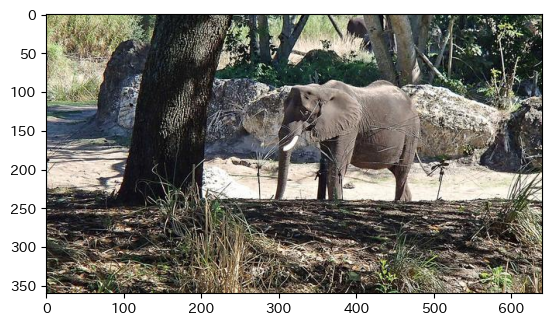

--------------------
['<s>##Instruction: Describe the image briefly. ##Question:  ##Answer: of this land, the land of the land, the land of this land, the land, the land, the land, of the land, the land, the land, of the land, the land, the land, the land, the land, the land, the land, the land, the of the land, the land, the the land, the the land, the the the land, the the the the the, the the the the the the, the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the']
##Inst

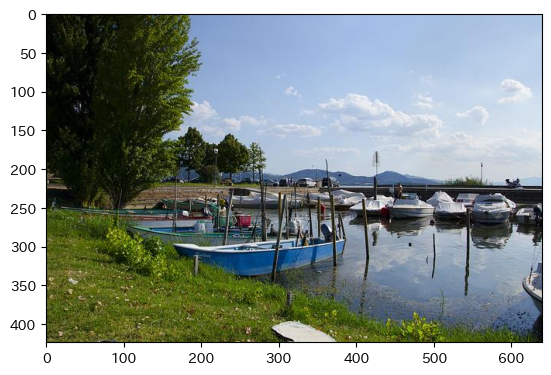

--------------------
['<s>##Instruction: Write a brief, yet comprehensive, description of the image. ##Question:  ##Answer: This is the local, the main, the local, the main, the local, the area, the local, the main, the local, the area, the local, the main, the local, the area, the main, the local, the main, the main, the local, the main, the main, the main, the local, the main, the main, the main, the main: the main, the main, the main, the main: the main, the main, the main: the main, the main, the main: the main, the main: the main, the local, the main: the main: the main, the main: the main: the main: the main: the main: the main: the main: the main: the main: the main: the main: the main: the main: the main: the main: the main: the main: the main: the main: the main: the main: the main: the main: the main:The main: the main:The main:The main:The main:F the main:F the main:F the']
##Instruction: Write a brief, yet comprehensive, description of the image. ##Question:  ##Answer: A wo

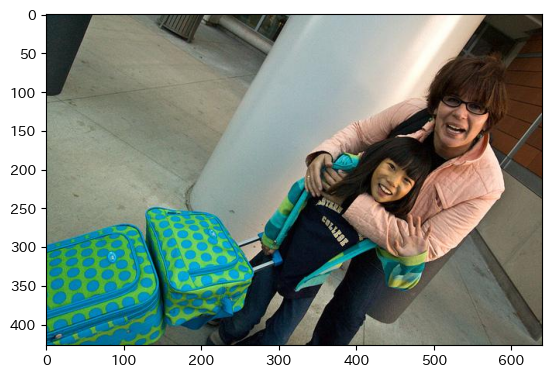

--------------------
['<s>##Instruction: Offer a succinct explanation of the picture presented. ##Question:  ##Answer:, this, and this, and the US, and this, and we are.\n, and this, and we are.\n, and this, and we are.\n, and this, and we are.\n, and this.\n\n\n\n $$.\n\n\n\n\n\n\n\n\n $$.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n, ...\n\n\n\n\n\n,\n,\n\n\n\n\n\n,\n,\n\n\n\n,\n\n\n\n\n,\n,\n,\n,\n,\n']
##Instruction: Offer a succinct explanation of the picture presented. ##Question:  ##Answer: A woman sitting on a piece of luggage in a field.


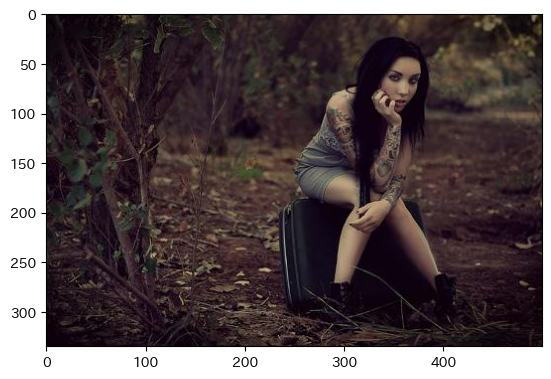

--------------------
['<s>##Instruction: Write a short and informative description that highlights the primary subjects and actions occurring in the given image. ##Question:  ##Answer: the colon, the colon, the colon, the colon, the colon, the colon, the colon, the colon, the colon, the colon, the colon, the colon, the colon, the colon, the colon the colon, the colon the. the colon the the. the the. the the the. the the the. the the the the the. the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the th

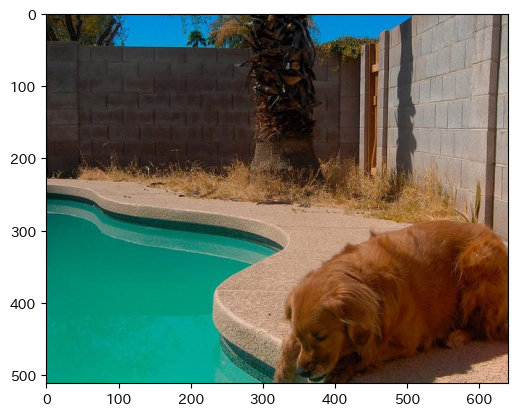

--------------------
['<s>##Instruction: Write a succinct description of the image, capturing its main components, the relationships between them, and any notable details. ##Question:  ##Answer: this land, you are going this land, you are going this land, you are going this land, you are going this land, you are going, you are you are going this land, you are you are going this are you are you are going this are you are you areyou areyou areyou areyou areyougelyyou areyou areyougay you areyou areyougay you areyougay you areyougay you areyougayyougbeyougayyougyougayyougbeyougayyougyougayyougayyougayyougyougayyougaygyougaygyougaygyougaygyougaygyougaygyougaygyougaygaygyougaygaygyougaygaygyougaygaygyougaygaygaygyougaygaygaygyougaygaygaygaygyougaygaygaygaygay']
##Instruction: Write a succinct description of the image, capturing its main components, the relationships between them, and any notable details. ##Question:  ##Answer: Shaggy dog gets dinner served on a plate.


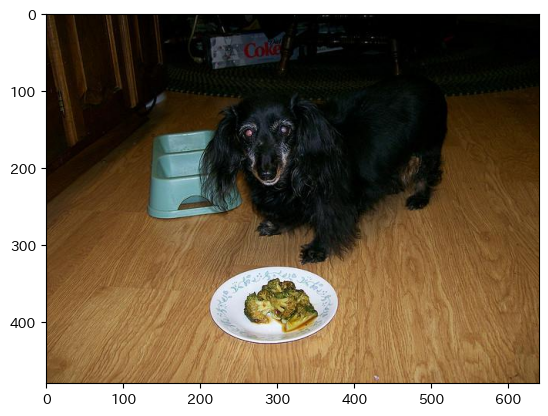

--------------------
['<s>##Instruction: For the given image, provide a one-sentence summary that captures the most important details. ##Question:  ##Answer:, the colon the colon the colon the colon the colon the US, the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire the entire th

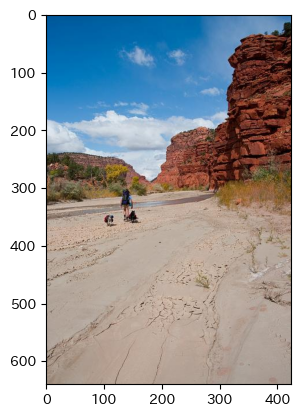

In [ ]:
coco_datasets = datasets.load_dataset("MMInstruction/M3IT", "coco")
test_dataset = coco_datasets["test"]
supervised_test_dataset = SupervisedDataset(model_name, vision_model_name, test_dataset, 256)

for i in range(170, 300, 10):
    data, img, text, full_text = supervised_test_dataset[i]
    print('-'*20)
    print(generate_text(model, data))
    print(full_text)
    plt.figure()
    plt.imshow(np.array(img))
    plt.show()
    plt.clf()
    plt.close()